In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 13:42:43.445857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 13:42:45.034776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 18850
end_idx = 19000
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(150, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(150, 96, 7)
(100800,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(150, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(150, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 13:42:54.775893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 13:42:57.725764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step
CPU time: 3209.418491150951 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

5/5 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.27336578 0.77343247 0.38198656 ... 0.58519963 0.75820475 0.10493005]
Fitness value of the best solution = 0.0013953670538089965


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

5/5 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


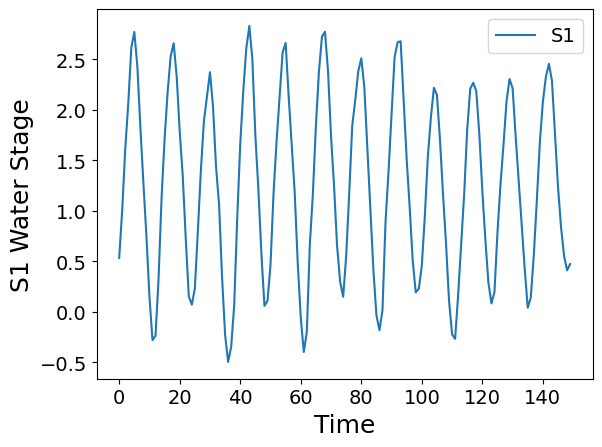

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low21.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.273366,0.773432,0.381987,0.864159,0.701853,0.840855,0.228084,0.241931,0.063766,0.320302,...,0.552530,0.386316,0.404151,0.853492,0.973650,0.699330,0.511350,0.036745,0.861115,0.480326
1,0.887131,0.592350,0.599013,0.895078,0.948771,0.365719,0.182432,0.901535,0.816749,0.740013,...,0.520165,0.066384,0.081719,0.566721,0.781025,0.717431,0.320531,0.549514,0.891943,0.487945
2,0.468101,0.763737,0.018688,0.483388,0.583278,0.036740,0.644301,0.692775,0.166897,0.241457,...,0.468141,0.686287,0.703462,0.391174,0.637417,0.190653,0.550603,0.611680,0.125867,0.122353
3,0.659503,0.149369,0.733373,0.438712,0.303575,0.417004,0.242516,0.370053,0.536097,0.910640,...,0.092120,0.884864,0.145962,0.943864,0.133483,0.855226,0.930412,0.541141,0.257963,0.957470
4,0.965707,0.116606,0.776224,0.688880,0.861194,0.794903,0.064484,0.087420,0.542061,0.186180,...,0.043991,0.873948,0.140246,0.650270,0.722522,0.431902,0.142747,0.292590,0.884752,0.213172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.697943,0.694002,0.592013,0.314520,0.006326,0.857532,0.763235,0.620331,0.679139,0.922168,...,0.345033,0.610051,0.552907,0.244749,0.931192,0.178988,0.378478,0.026750,0.199638,0.329280
146,0.749638,0.741143,0.190324,0.348602,0.504369,0.383502,0.139086,0.210782,0.346857,0.583450,...,0.157787,0.791551,0.780502,0.430107,0.838339,0.400390,0.649840,0.241149,0.857827,0.880628
147,0.678482,0.963269,0.752342,0.329224,0.888184,0.044036,0.414603,0.861212,0.119922,0.241411,...,0.354405,0.549442,0.003965,0.111228,0.853015,0.896731,0.322450,0.370388,0.118307,0.597219
148,0.901052,0.110779,0.701670,0.733793,0.124373,0.523686,0.814345,0.492142,0.152418,0.576490,...,0.341389,0.152064,0.497363,0.872097,0.362793,0.886993,0.881473,0.502253,0.665918,0.925397


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low21.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.534772,0.295807,0.689281,0.551281,1.009989,1.259863,1.065131,1.081161,1.565580,1.524977,...,1.454729,1.376621,0.704645,0.902290,0.961276,0.861787,0.255416,0.511102,0.659817,0.440207
1,1.010201,1.119333,1.128204,1.038388,1.575115,1.599328,1.532052,1.644210,2.058462,1.720723,...,1.152348,0.929492,0.250284,0.242211,0.678080,0.380338,0.079594,0.159911,0.401954,0.226036
2,1.613502,1.493844,1.629070,1.679941,2.044145,1.871250,1.963281,2.063585,2.494941,2.228970,...,0.583523,0.303455,0.028761,0.300485,0.319829,0.152345,0.217135,0.263962,0.475924,0.358792
3,2.064303,2.262092,2.064887,2.077135,2.467453,2.552159,2.393389,2.477275,2.833545,2.624574,...,0.296455,0.155703,0.287527,0.196518,0.499621,0.434709,0.889317,1.229402,1.098860,1.096739
4,2.612981,2.619853,2.614634,2.633030,2.705159,2.793119,2.620892,2.706612,2.436713,2.452714,...,0.405965,0.310953,0.769101,0.752341,0.858093,0.889830,1.409356,1.548668,1.511787,1.504303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.238388,1.205134,1.355336,1.302029,0.835440,0.777287,0.918101,0.867034,0.475779,0.189990,...,2.372518,2.532375,2.364344,2.420188,2.384133,2.573708,2.085152,2.093520,2.137418,2.259129
146,0.841570,1.114373,0.850521,0.953425,0.404682,0.333884,0.379000,0.376042,0.386261,0.447170,...,2.434282,2.515422,2.056768,2.356722,2.131301,2.239868,1.783040,1.836511,1.909649,1.923040
147,0.554528,0.408027,0.610673,0.534478,0.346894,0.168675,0.293157,0.207851,0.596299,0.580162,...,2.110592,2.211595,1.684246,1.658661,1.780506,1.857827,1.433284,1.393047,1.616986,1.624779
148,0.411499,0.514607,0.530813,0.374412,0.485972,0.427711,0.535876,0.453758,1.043946,1.104630,...,1.692794,1.765867,1.336995,1.226786,1.507784,1.569067,1.107915,1.318718,1.388144,1.357040


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 734, areas: 148.4259360263386


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

5/5 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 1213, areas: 303.8682367746296
